In [1]:
import deepxde as dde
import numpy as np
from deepxde.backend import pytorch
import torch
import matplotlib.pyplot as plt
from SIRD_deepxde_class import SIRD_deepxde_net
from SIRD_deepxde_class import Plot

seed = 0
np.random.seed(seed)
dde.config.set_random_seed(seed)

Using backend: pytorch



# Create synthetic data

In [2]:
alpha_real = 0.2
beta_real = 0.05
gamma_real = 0.01

total  [2.04643018e+05 1.47928048e+03 3.99489808e+06 7.98979617e+05]
total  4999999.999999999


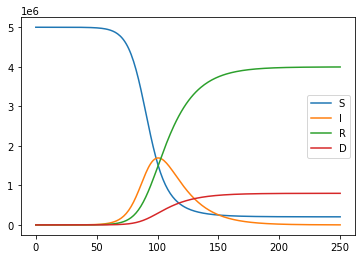

In [3]:
import ODE_SIR
solver = ODE_SIR.ODESolver()
t_synth, wsol_synth, N = solver.solve_SIRD(alpha_real, beta_real, gamma_real)
solver.plot_SIRD(t_synth, wsol_synth)

Use cell below if we want to subset timestep - ie simulate if we are at an early stage in the pandemic so have limited data

In [4]:
# keep this even if not subsetting
t = t_synth
wsol = wsol_synth

# subset
max_timestep = 100
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]

# Create model
Code has been wrapped in a custom class that wraps around the deepxde model

In [5]:
model = SIRD_deepxde_net(t, wsol)

In [6]:
model.init_model(print_every=1000)

Compiling model...
'compile' took 0.000277 s



In [7]:
model.train_model(iterations=10000)

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [2.16e-03, 1.08e-03, 1.03e-02, 8.25e-04, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 1.33e-01, 3.70e-02, 6.51e-01, 3.40e-01, 8.90e-02, 1.60e-01, 1.10e+00, 3.16e-01]    [2.16e-03, 1.08e-03, 1.03e-02, 8.25e-04, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 1.33e-01, 3.70e-02, 6.51e-01, 3.40e-01, 8.90e-02, 1.60e-01, 1.10e+00, 3.16e-01]    []  
1000      [4.42e-06, 1.03e-06, 4.82e-06, 9.40e-07, 3.05e-07, 8.51e-07, 1.04e-07, 6.02e-08, 4.09e-04, 1.39e-05, 1.94e-04, 3.35e-05, 3.90e-04, 3.16e-05, 6.78e-05, 3.54e-05]    [4.42e-06, 1.03e-06, 4.82e-06, 9.40e-07, 3.05e-07, 8.51e-07, 1.04e-07, 6.02e-08, 4.09e-04, 1.39e-05, 1.94e-04, 3.3

# Investigate output
First use the predicted parameters from the neural network to solve the ODE

In [8]:
alpha_nn, beta_nn, gamma_nn = model.get_best_params()
t_nn_param, wsol_nn_param, N_nn_param = solver.solve_SIRD(alpha_nn, beta_nn, gamma_nn)

In [9]:
# we need to set the synthetic data as it comes from outside the network
# the two functions below sets the synthetic data
model.set_synthetic_data(t_synth, wsol_synth) 
model.set_nn_synthetic_data(t_nn_param, wsol_nn_param)

In [10]:
plot = Plot(model) # class that contains plotting functions

The plots below show two things:  
* A comparison between the data we have and what the PINN predicts in this range
* A comparison between the synthetic data in the whole range and the result from using the predicted parameters in the ODE solver

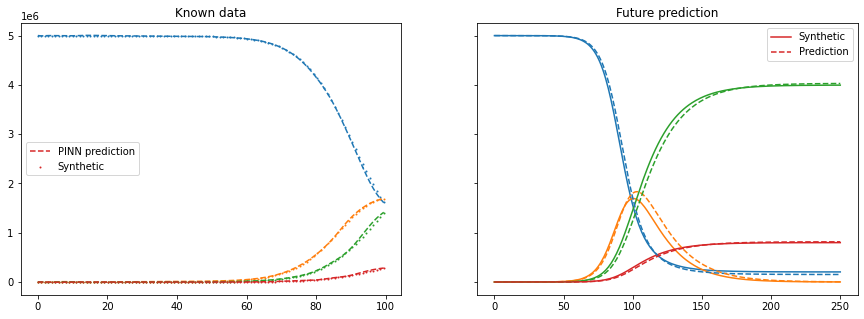

In [11]:
plot.show_known_and_prediction()

# Same as before with even less data
The timing of the data is important. We want to predict as early as possible in the pandemic, so investigate what the effect is of having less data.

In [12]:
max_timestep = 85
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]

In [13]:
model_less = SIRD_deepxde_net(t, wsol)
model_less.init_model(print_every=1000)
model_less.train_model(iterations=11000)

Compiling model...
'compile' took 0.000123 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [2.36e-03, 2.24e-03, 1.43e-03, 1.73e-03, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 1.19e+00, 3.51e-02, 3.32e-02, 5.45e-02, 8.15e-01, 8.83e-03, 4.04e-02, 7.73e-02]    [2.36e-03, 2.24e-03, 1.43e-03, 1.73e-03, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 1.19e+00, 3.51e-02, 3.32e-02, 5.45e-02, 8.15e-01, 8.83e-03, 4.04e-02, 7.73e-02]    []  
1000      [8.26e-06, 4.32e-06, 5.36e-06, 5.40e-07, 1.07e-04, 3.72e-04, 3.05e-05, 6.03e-05, 3.00e-03, 2.04e-03, 3.23e-04, 1.27e-04, 1.30e-03, 1.19e-03, 2.41e-04, 2.11e-04]    [8.26e-06, 4.32e-06, 5.36e-06, 5.40e-07, 1.07e-04, 3.72e-04, 3.05e-0

In [14]:
alpha_nn, beta_nn, gamma_nn = model_less.get_best_params()
print(f'Alpha: {alpha_nn}, beta: {beta_nn}, gamma: {gamma_nn}')
t_nn_param, wsol_nn_param, N_nn_param = solver.solve_SIRD(alpha_nn, beta_nn, gamma_nn)

Alpha: 0.172, beta: 0.0419, gamma: 0.00888


In [15]:
model_less.set_synthetic_data(t_synth, wsol_synth)
model_less.set_nn_synthetic_data(t_nn_param, wsol_nn_param)
plot_less = Plot(model_less)

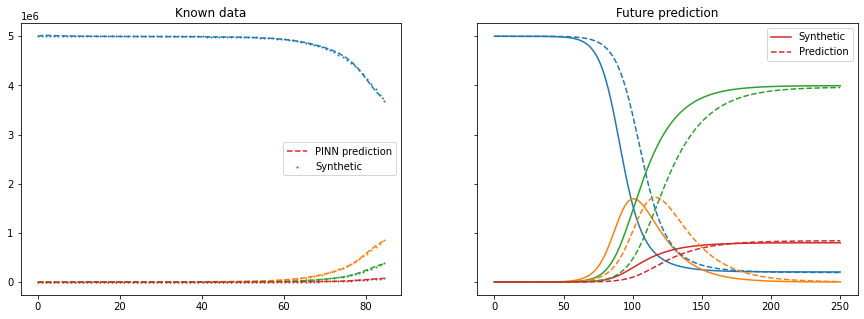

In [16]:
plot_less.show_known_and_prediction()

# Even less data

In [17]:
max_timestep = 75
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]

In [18]:
model_less_2 = SIRD_deepxde_net(t, wsol)
model_less_2.init_model(print_every=1000)
model_less_2.train_model(iterations=11000)

Compiling model...
'compile' took 0.000121 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [8.60e-04, 3.60e-03, 1.09e-03, 4.70e-04, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 1.14e+00, 4.36e-02, 2.20e-01, 9.94e-03, 7.68e-01, 1.11e-02, 3.31e-01, 2.30e-02]    [8.60e-04, 3.60e-03, 1.09e-03, 4.70e-04, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 1.14e+00, 4.36e-02, 2.20e-01, 9.94e-03, 7.68e-01, 1.11e-02, 3.31e-01, 2.30e-02]    []  
1000      [5.66e-06, 3.30e-06, 6.17e-06, 2.35e-06, 2.53e-08, 3.79e-05, 4.99e-06, 1.23e-06, 7.26e-04, 5.37e-04, 5.43e-05, 1.19e-06, 7.55e-05, 7.11e-08, 8.96e-06, 5.47e-06]    [5.66e-06, 3.30e-06, 6.17e-06, 2.35e-06, 2.53e-08, 3.79e-05, 4.99e-0

In [19]:
alpha_nn, beta_nn, gamma_nn = model_less_2.get_best_params()
print(f'Alpha: {alpha_nn}, beta: {beta_nn}, gamma: {gamma_nn}')
t_nn_param, wsol_nn_param, N_nn_param = solver.solve_SIRD(alpha_nn, beta_nn, gamma_nn)

Alpha: 0.132, beta: 0.0308, gamma: 0.00256


In [20]:
model_less_2.set_synthetic_data(t_synth, wsol_synth)
model_less_2.set_nn_synthetic_data(t_nn_param, wsol_nn_param)
plot_less_2 = Plot(model_less_2)

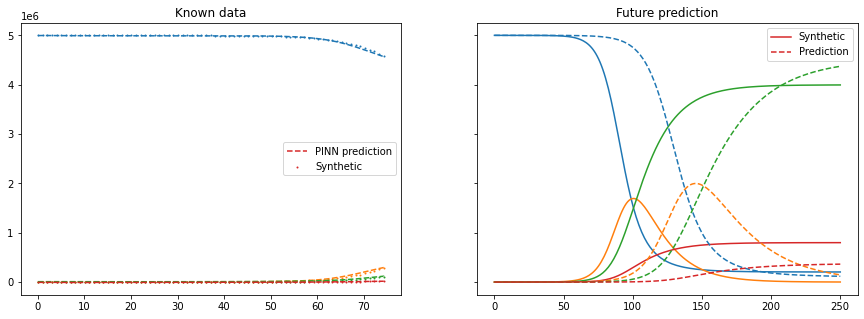

In [21]:
plot_less_2.show_known_and_prediction()

# With noise

In [22]:
max_timestep = 100
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]

In [24]:
wsol = solver.add_noise(wsol, scale_pct=0.05)

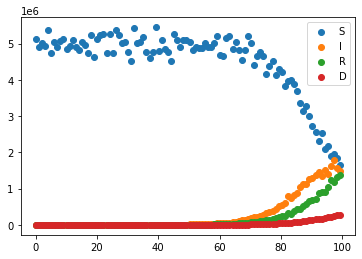

In [25]:
solver.plot_SIRD_scatter(t, wsol)

In [26]:
model_noise = SIRD_deepxde_net(t, wsol)
model_noise.init_model(print_every=1000)
model_noise.train_model(iterations=10000)

Compiling model...
'compile' took 0.000273 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [8.53e-04, 3.14e-02, 6.38e-03, 4.46e-03, 1.00e+00, 4.04e-12, 0.00e+00, 0.00e+00, 1.69e+00, 4.98e-01, 2.84e-01, 3.03e-02, 5.44e-01, 7.41e-01, 6.42e-01, 1.09e-02]    [8.53e-04, 3.14e-02, 6.38e-03, 4.46e-03, 1.00e+00, 4.04e-12, 0.00e+00, 0.00e+00, 1.69e+00, 4.98e-01, 2.84e-01, 3.03e-02, 5.44e-01, 7.41e-01, 6.42e-01, 1.09e-02]    []  
1000      [3.67e-06, 5.03e-06, 9.83e-06, 9.95e-07, 5.26e-05, 1.00e-06, 3.27e-05, 1.67e-06, 4.24e-03, 6.67e-04, 1.21e-03, 7.05e-05, 1.40e-03, 1.63e-04, 1.49e-04, 6.89e-07]    [3.67e-06, 5.03e-06, 9.83e-06, 9.95e-07, 5.26e-05, 1.00e-06, 3.27e-0

In [27]:
alpha_nn, beta_nn, gamma_nn = model_noise.get_best_params()
print(f'Alpha: {alpha_nn}, beta: {beta_nn}, gamma: {gamma_nn}')
t_nn_param, wsol_nn_param, N_nn_param = solver.solve_SIRD(alpha_nn, beta_nn, gamma_nn)

Alpha: 0.201, beta: 0.0505, gamma: 0.0123


In [28]:
model_noise.set_synthetic_data(t_synth, wsol_synth)
model_noise.set_nn_synthetic_data(t_nn_param, wsol_nn_param)
plot_noise = Plot(model_noise)

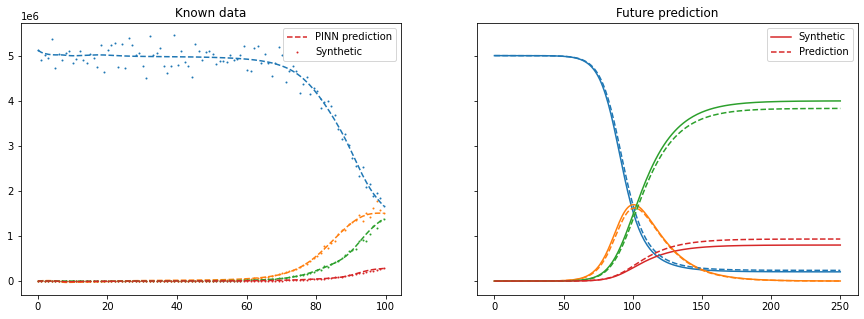

In [29]:
plot_noise.show_known_and_prediction()

Compiling model...
'compile' took 0.000137 s

Training model...

Step      Train loss                                                                                                                                                                                                  Test loss                                                                                                                                                                                                   Test metric
0         [1.66e-02, 5.35e-02, 6.23e-03, 6.06e-03, 1.00e+00, 4.04e-12, 0.00e+00, 0.00e+00, 2.75e+00, 5.75e-01, 5.74e-02, 1.07e-01, 1.19e+00, 9.04e-01, 2.72e-03, 1.42e-01, 1.20e-03, 2.70e-04, 1.00e-04, 4.36e-07]    [1.66e-02, 5.35e-02, 6.23e-03, 6.06e-03, 1.00e+00, 4.04e-12, 0.00e+00, 0.00e+00, 2.75e+00, 5.75e-01, 5.74e-02, 1.07e-01, 1.19e+00, 9.04e-01, 2.72e-03, 1.42e-01, 1.20e-03, 2.70e-04, 1.00e-04, 4.36e-07]    []  
1000      [1.37e-05, 5.76e-06, 3.28e-06, 2.03e-06, 1.03e-05, 2.84e-05, 7.37e-05, 5

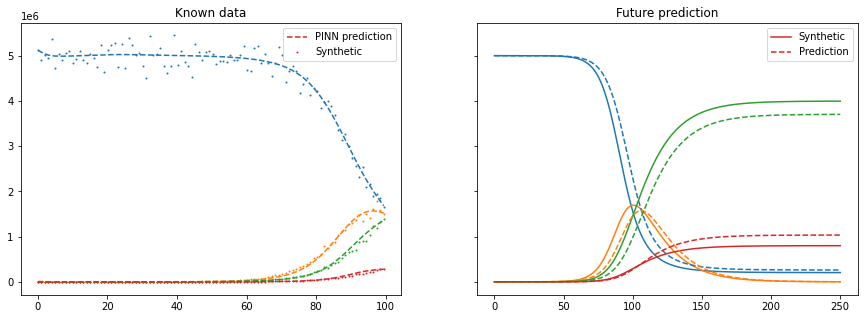

In [30]:
model_noise_neumann = SIRD_deepxde_net(t, wsol, with_neumann=True)
model_noise_neumann.init_model(print_every=1000)
model_noise_neumann.train_model(iterations=10000)
alpha_nn, beta_nn, gamma_nn = model_noise_neumann.get_best_params()
print(f'Alpha: {alpha_nn}, beta: {beta_nn}, gamma: {gamma_nn}')
t_nn_param, wsol_nn_param, N_nn_param = solver.solve_SIRD(alpha_nn, beta_nn, gamma_nn)
model_noise_neumann.set_synthetic_data(t_synth, wsol_synth)
model_noise_neumann.set_nn_synthetic_data(t_nn_param, wsol_nn_param)
plot_noise_neumann = Plot(model_noise_neumann)
plot_noise_neumann.show_known_and_prediction()

Compiling model...
'compile' took 0.000136 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [9.29e-05, 1.20e-03, 1.19e-03, 5.53e-04, 1.00e+00, 4.20e-12, 0.00e+00, 0.00e+00, 7.92e-01, 1.87e-02, 1.59e-01, 2.15e-02, 4.06e-01, 2.57e-03, 8.49e-02, 2.08e-02]    [9.29e-05, 1.20e-03, 1.19e-03, 5.53e-04, 1.00e+00, 4.20e-12, 0.00e+00, 0.00e+00, 7.92e-01, 1.87e-02, 1.59e-01, 2.15e-02, 4.06e-01, 2.57e-03, 8.49e-02, 2.08e-02]    []  
1000      [3.36e-05, 9.23e-06, 1.29e-06, 1.06e-06, 1.15e-06, 8.53e-07, 1.41e-06, 1.61e-08, 3.50e-03, 3.31e-04, 6.48e-05, 1.39e-05, 6.35e-04, 1.51e-04, 9.96e-07, 4.71e-07]    [3.36e-05, 9.23e-06, 1.29e-06, 1.06e-06, 1.15e-06, 8.53e-07, 1.41e-0

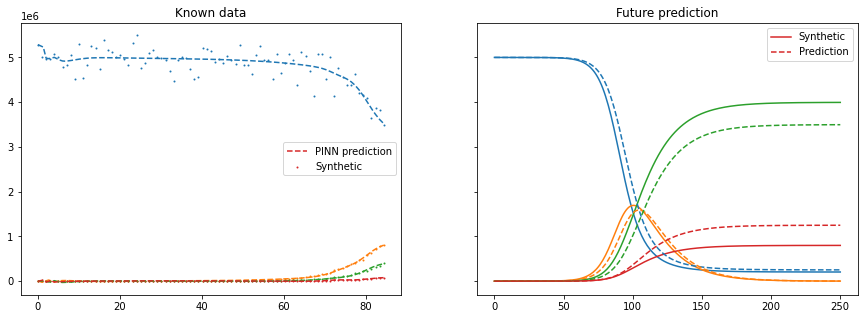

In [32]:
max_timestep = 85
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]
wsol = solver.add_noise(wsol, scale_pct=0.05)

model_noise_less = SIRD_deepxde_net(t, wsol)
model_noise_less.init_model(print_every=1000)
model_noise_less.train_model(iterations=10000)
alpha_nn, beta_nn, gamma_nn = model_noise_less.get_best_params()
print(f'Alpha: {alpha_nn}, beta: {beta_nn}, gamma: {gamma_nn}')
t_nn_param, wsol_nn_param, N_nn_param = solver.solve_SIRD(alpha_nn, beta_nn, gamma_nn)
model_noise_less.set_synthetic_data(t_synth, wsol_synth)
model_noise_less.set_nn_synthetic_data(t_nn_param, wsol_nn_param)
plot_noise_less = Plot(model_noise_less)
plot_noise_less.show_known_and_prediction()

# Normal neural network

Epoch  1 : Train Loss 0.003277
Epoch 101 : Train Loss 0.000320
Epoch 201 : Train Loss 0.000319
Epoch 301 : Train Loss 0.000319
Epoch 401 : Train Loss 0.000318
Epoch 501 : Train Loss 0.000317
Epoch 601 : Train Loss 0.000315
Epoch 701 : Train Loss 0.000310
Epoch 801 : Train Loss 0.000282
Epoch 901 : Train Loss 0.000086
Epoch 1001 : Train Loss 0.000014
Epoch 1101 : Train Loss 0.000003
Epoch 1201 : Train Loss 0.000001
Epoch 1301 : Train Loss 0.000001
Epoch 1401 : Train Loss 0.000000
Epoch 1501 : Train Loss 0.000000
Epoch 1601 : Train Loss 0.000000
Epoch 1701 : Train Loss 0.000000
Epoch 1801 : Train Loss 0.000000
Epoch 1901 : Train Loss 0.000000
Epoch 2001 : Train Loss 0.000000
Epoch 2101 : Train Loss 0.000000
Epoch 2201 : Train Loss 0.000000
Epoch 2301 : Train Loss 0.000000
Epoch 2401 : Train Loss 0.000000
Epoch  1 : Train Loss 0.000716
Epoch 101 : Train Loss 0.000102
Epoch 201 : Train Loss 0.000102
Epoch 301 : Train Loss 0.000101
Epoch 401 : Train Loss 0.000101
Epoch 501 : Train Loss 0.00

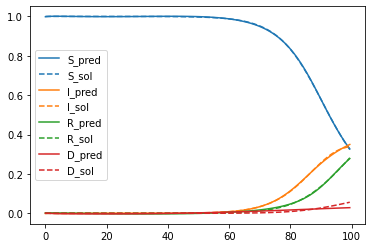

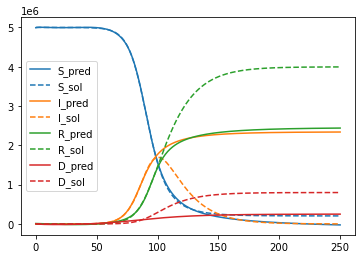

In [33]:
from SIRD_normal_nn import SIRD_net
max_timestep = 100
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]

net = SIRD_net(t, wsol)
net.train()
net.plot(t_synth, wsol_synth)